In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
sns.set()

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [4]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [7]:
missing_percentage(train_data)

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageCond,81,5.55
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55


In [8]:
train_data = train_data.drop(columns=['Id','Alley','PoolQC','Fence','MiscFeature'])

In [9]:
missing_percentage(test_data)

,Total,Percent
PoolQC,1456,99.79
MiscFeature,1408,96.50
Alley,1352,92.67
Fence,1169,80.12
FireplaceQu,730,50.03
LotFrontage,227,15.56
GarageCond,78,5.35
GarageQual,78,5.35
GarageYrBlt,78,5.35
GarageFinish,78,5.35


In [10]:
test_data = test_data.drop(columns=['Id','Alley','PoolQC','Fence','MiscFeature'])

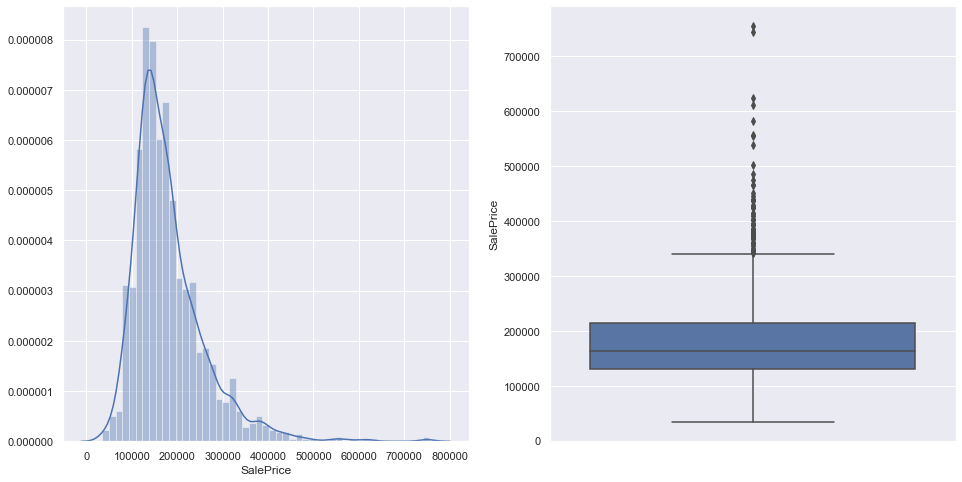

In [11]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.distplot(train_data['SalePrice'], norm_hist=True)
plt.subplot(1,2,2)
sns.boxplot(train_data['SalePrice'], orient='v');

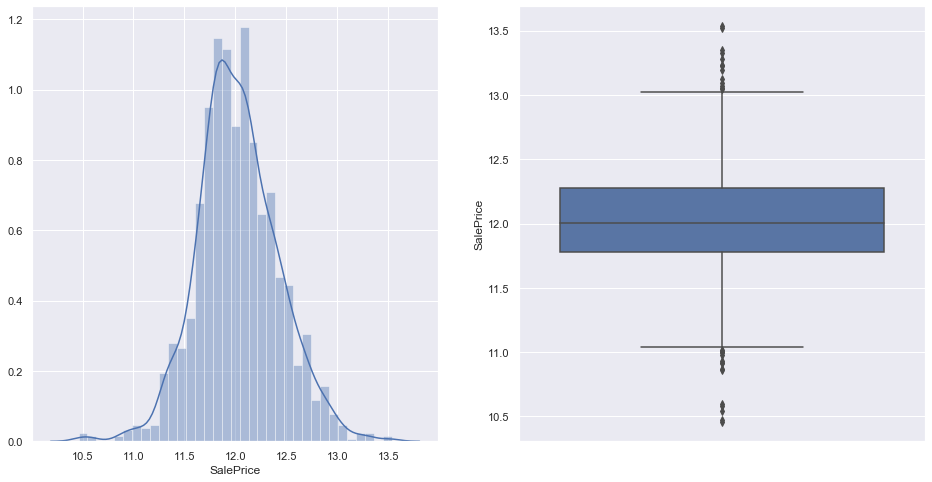

In [12]:
## trainsforming target variable using numpy.log1p, 
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

## Plotting the newly transformed response variable
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.distplot(train_data['SalePrice'], norm_hist=True)
plt.subplot(1,2,2)
sns.boxplot(train_data['SalePrice'], orient='v');

In [13]:
## Getting the correlation of all the features with target variable. 
(train_data.corr())["SalePrice"].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePrice, dtype: float64

In [14]:
def scatterplot(x):
    plt.subplots(figsize = (12,8))
    ## Plotting target variable with predictor variable(OverallQual)
    sns.scatterplot(x = x , y = train_data.SalePrice);

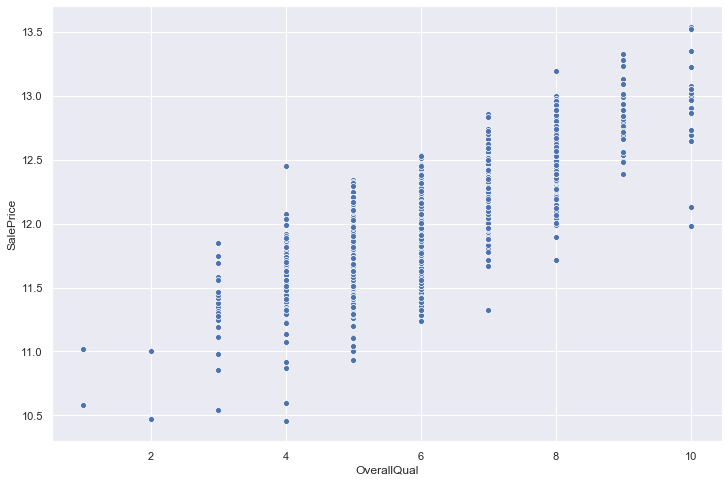

In [15]:
scatterplot(train_data.OverallQual)

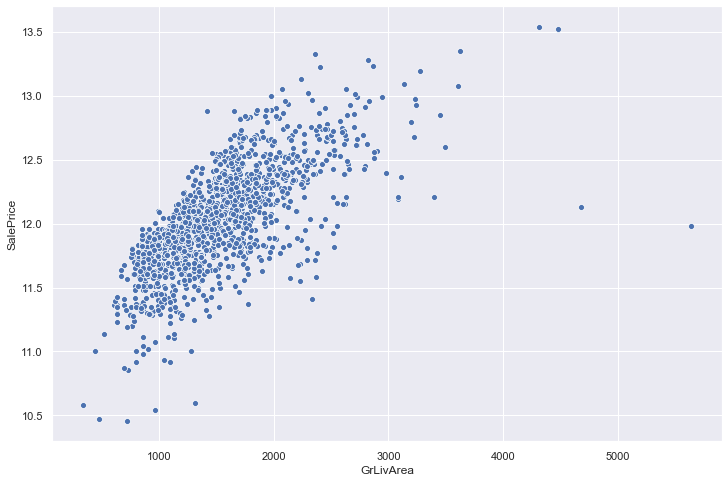

In [16]:
scatterplot(train_data.GrLivArea)

In [17]:
## save a copy of this dataset so that any changes later on can be compared side by side.
previous_train = train_data.copy()

## Deleting those two values with outliers. 
train_data = train_data[train_data.GrLivArea < 4500]
train_data.reset_index(drop = True, inplace = True)

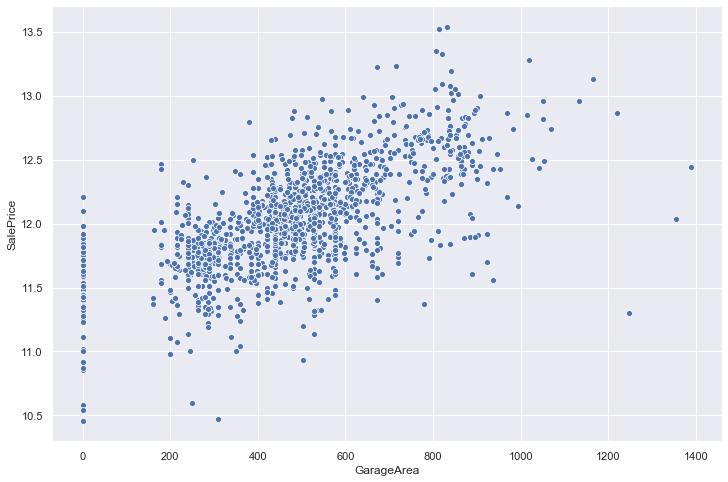

In [18]:
scatterplot(train_data.GarageArea)

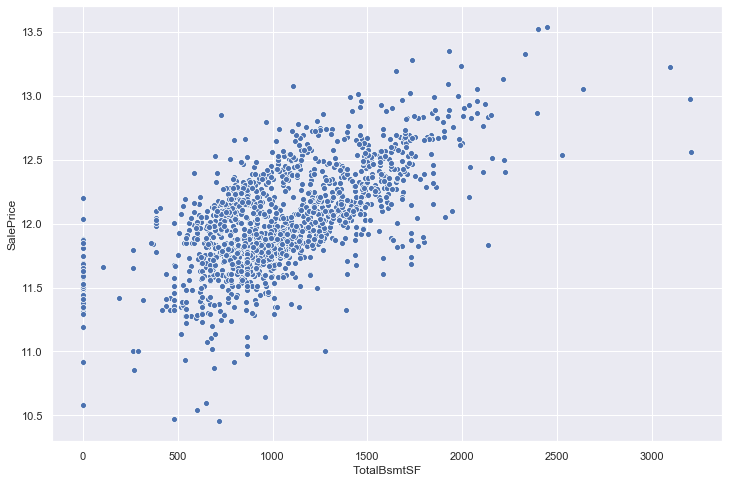

In [19]:
scatterplot(train_data.TotalBsmtSF)

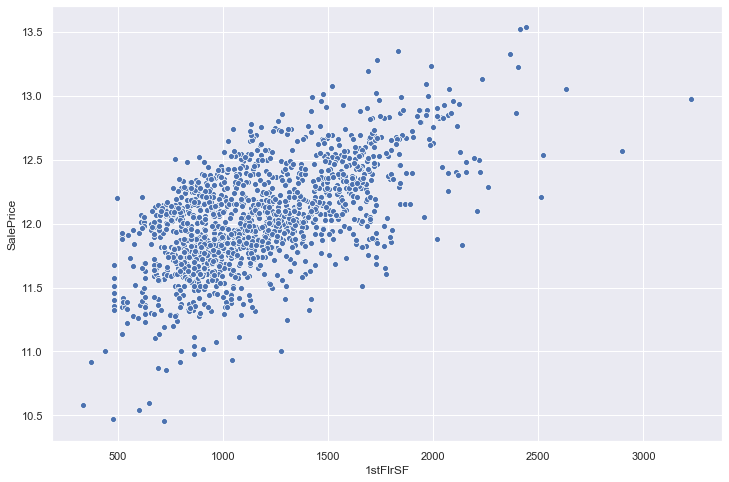

In [20]:
scatterplot(train_data['1stFlrSF'])

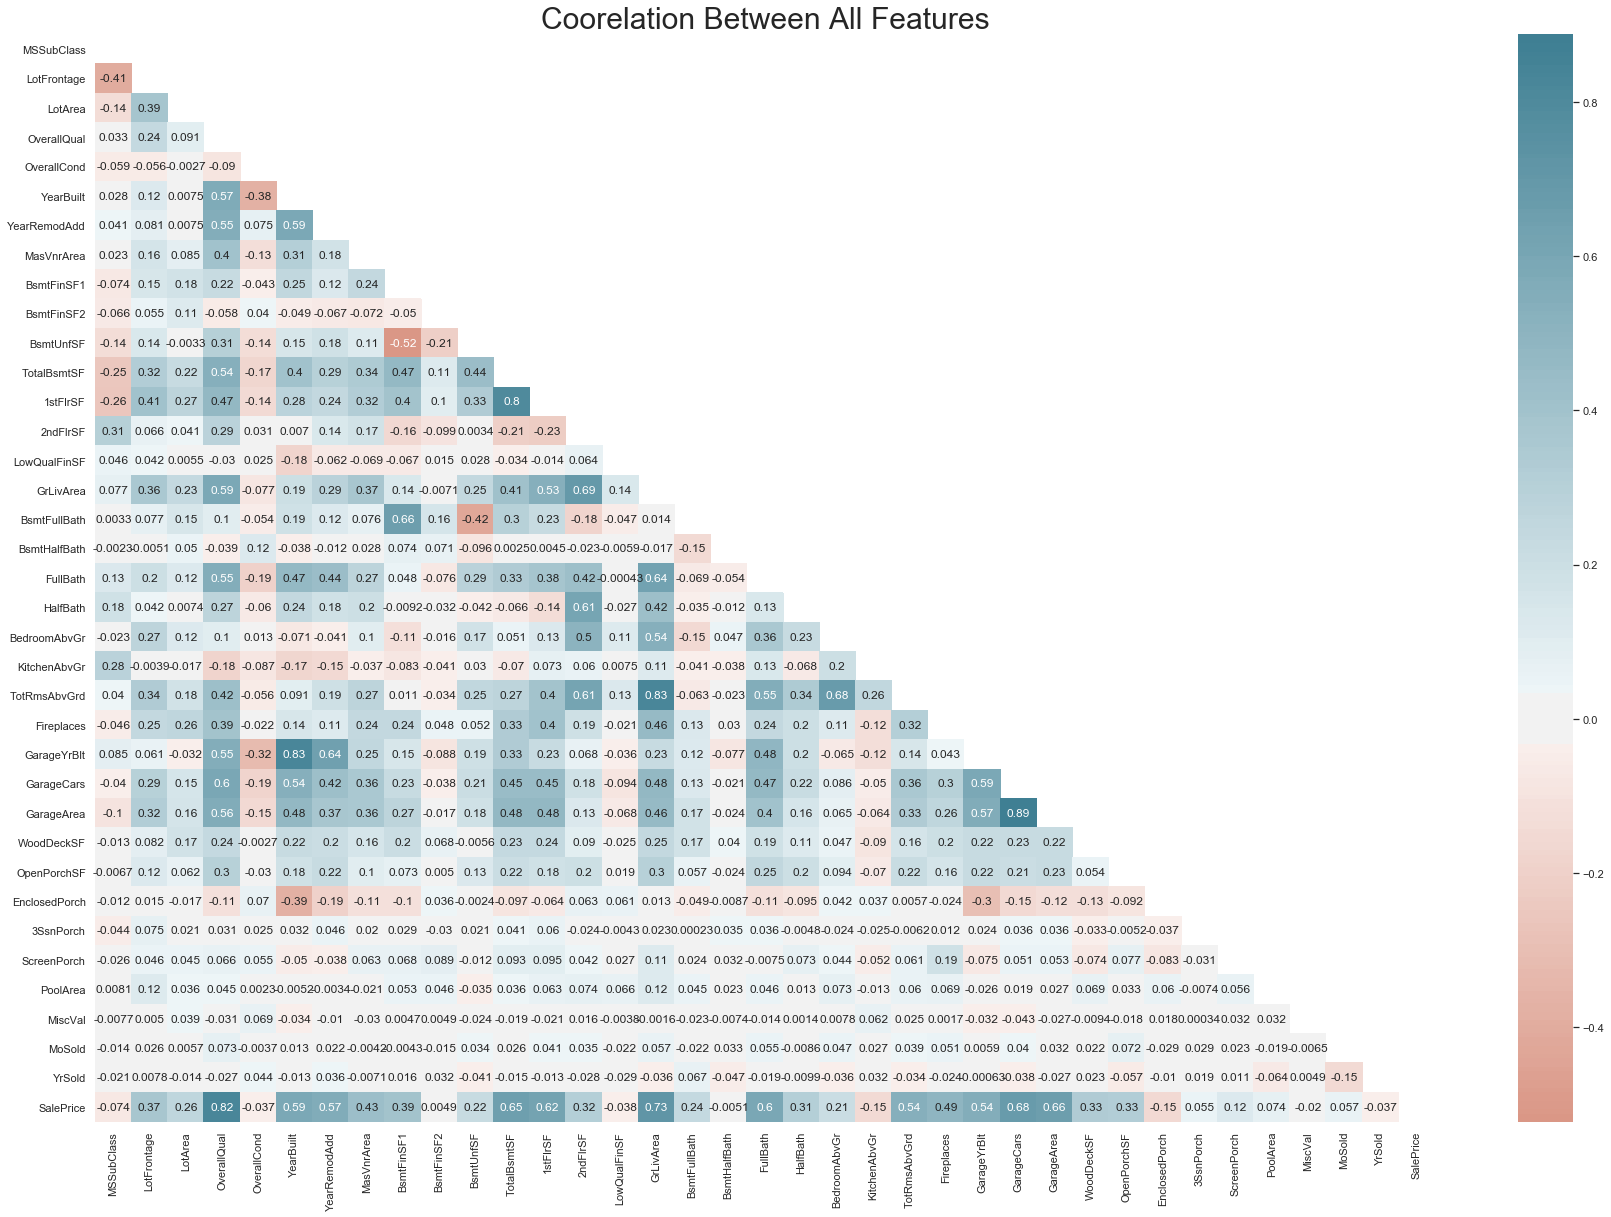

In [21]:
## Plot fig sizing.
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

#Generate a mask for the removing upper triangle
mask = np.zeros_like(train_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(train_data.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            mask = mask, 
            annot=True, 
            center = 0, 
           );
## Give title. 
plt.title("Coorelation Between All Features", fontsize = 30);

In [22]:
## Combining train and test datasets together so that we can do all the work at once. 
all_data = pd.concat((train_data, test_data)).reset_index(drop = True)

SalePrice = all_data['SalePrice'][:1458]
## Dropping the target variable. 
all_data.drop(['SalePrice'], axis = 1, inplace = True)

In [23]:
all_data = all_data.drop(columns=['1stFlrSF','TotRmsAbvGrd','GarageYrBlt','GarageArea'])

In [24]:
print(all_data.shape)

(2917, 71)


In [25]:
missing_percentage(all_data)

,Total,Percent
FireplaceQu,1420,48.68
LotFrontage,486,16.66
GarageCond,159,5.45
GarageFinish,159,5.45
GarageQual,159,5.45
GarageType,157,5.38
BsmtCond,82,2.81
BsmtExposure,82,2.81
BsmtQual,81,2.78
BsmtFinType2,80,2.74


In [26]:
## Some missing values are intentionally left blank. 
missing_val_col = ["FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']

for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')

In [27]:
## In the following features the null values are there for a purpose, so we replace them with "0"
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath',
                    'GarageCars',
                    'MasVnrArea']

for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)

In [28]:
## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))

In [29]:
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2006,WD,Normal
2913,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,24,0,0,0,0,0,4,2006,WD,Abnorml
2914,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,9,2006,WD,Abnorml
2915,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,32,0,0,0,0,700,7,2006,WD,Normal


In [30]:
all_data.shape

(2917, 71)

In [31]:
missing_percentage(all_data)

,Total,Percent
MSZoning,4,0.14
Functional,2,0.07
Utilities,2,0.07
SaleType,1,0.03
Exterior1st,1,0.03
Electrical,1,0.03
KitchenQual,1,0.03
Exterior2nd,1,0.03


In [32]:
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr") 

In [33]:
missing_percentage(all_data)

,Total,Percent


In [34]:
# class are given in numerical; therefore converted to categorical variables. 
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

# Important years and months that should be categorical variables not numerical. 
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr")

In [35]:
numeric_feats = numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_feats

MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
GrLivArea         1.068750
LotFrontage       1.058803
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
Fireplaces        0.725278
HalfBath          0.696666
TotalBsmtSF       0.671751
BsmtFullBath      0.622415
OverallCond       0.569314
BedroomAbvGr      0.326568
OverallQual       0.189591
FullBath          0.165514
GarageCars       -0.219297
YearRemodAdd     -0.450134
YearBuilt        -0.599194
dtype: float64

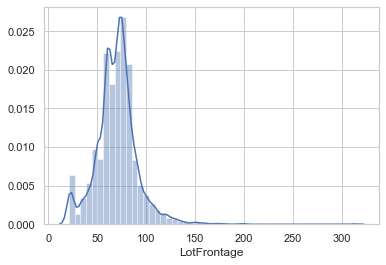

In [36]:
sns.distplot(all_data['LotFrontage']);

In [37]:
def fixing_skewness(df):#This function takes in a dataframe and return fixed skewed dataframe
    ## Import necessary modules
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))

In [38]:
fixing_skewness(all_data)

D:\Softwares\anaconda3\envs\ML\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
D:\Softwares\anaconda3\envs\ML\lib\site-packages\scipy\stats\stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


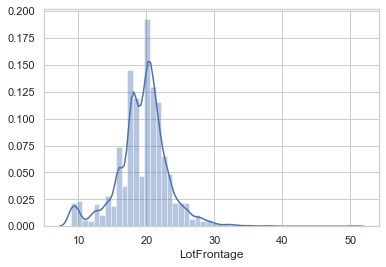

In [39]:
sns.distplot(all_data['LotFrontage']);

In [40]:
all_data.shape

(2917, 71)

In [41]:
BsmtQual = pd.get_dummies(all_data['BsmtQual'],drop_first=True)
BsmtCond = pd.get_dummies(all_data['BsmtCond'],drop_first=True)
BsmtExposure = pd.get_dummies(all_data['BsmtExposure'],drop_first=True)
BsmtFinType1 = pd.get_dummies(all_data['BsmtFinType1'],drop_first=True)
BsmtFinType2 = pd.get_dummies(all_data['BsmtFinType2'],drop_first=True)
FireplaceQu = pd.get_dummies(all_data['FireplaceQu'],drop_first=True)
GarageType = pd.get_dummies(all_data['GarageType'],drop_first=True)
GarageFinish = pd.get_dummies(all_data['GarageFinish'],drop_first=True)
GarageQual = pd.get_dummies(all_data['GarageQual'],drop_first=True)
GarageCond = pd.get_dummies(all_data['GarageCond'],drop_first=True)
MSSubClass = pd.get_dummies(all_data['MSSubClass'],drop_first=True)
MSZoning = pd.get_dummies(all_data['MSZoning'],drop_first=True)
Street = pd.get_dummies(all_data['Street'],drop_first=True)
LotShape = pd.get_dummies(all_data['LotShape'],drop_first=True)
LandContour = pd.get_dummies(all_data['LandContour'],drop_first=True)
Utilities = pd.get_dummies(all_data['Utilities'],drop_first=True)
LotConfig = pd.get_dummies(all_data['LotConfig'],drop_first=True)
LandSlope = pd.get_dummies(all_data['LandSlope'],drop_first=True)
Neighborhood = pd.get_dummies(all_data['Neighborhood'],drop_first=True)
Condition1 = pd.get_dummies(all_data['Condition1'],drop_first=True)
Condition2 = pd.get_dummies(all_data['Condition2'],drop_first=True)
BldgType = pd.get_dummies(all_data['BldgType'],drop_first=True)
HouseStyle = pd.get_dummies(all_data['HouseStyle'],drop_first=True)
OverallCond = pd.get_dummies(all_data['OverallCond'],drop_first=True)
RoofStyle = pd.get_dummies(all_data['RoofStyle'],drop_first=True)
RoofMatl = pd.get_dummies(all_data['RoofMatl'],drop_first=True)
Exterior1st = pd.get_dummies(all_data['Exterior1st'],drop_first=True)
Exterior2nd = pd.get_dummies(all_data['Exterior2nd'],drop_first=True)
MasVnrType = pd.get_dummies(all_data['MasVnrType'],drop_first=True)
ExterQual = pd.get_dummies(all_data['ExterQual'],drop_first=True)
ExterCond = pd.get_dummies(all_data['ExterCond'],drop_first=True)
Foundation = pd.get_dummies(all_data['Foundation'],drop_first=True)
BsmtQual = pd.get_dummies(all_data['BsmtQual'],drop_first=True)
Heating = pd.get_dummies(all_data['Heating'],drop_first=True)
HeatingQC = pd.get_dummies(all_data['HeatingQC'],drop_first=True)
CentralAir = pd.get_dummies(all_data['CentralAir'],drop_first=True)
Electrical = pd.get_dummies(all_data['Electrical'],drop_first=True)
KitchenQual = pd.get_dummies(all_data['KitchenQual'],drop_first=True)
Functional = pd.get_dummies(all_data['Functional'],drop_first=True)
PavedDrive = pd.get_dummies(all_data['PavedDrive'],drop_first=True)
SaleType = pd.get_dummies(all_data['SaleType'],drop_first=True)
SaleCondition = pd.get_dummies(all_data['SaleCondition'],drop_first=True)
YrSold = pd.get_dummies(all_data['YrSold'],drop_first=True)
MoSold = pd.get_dummies(all_data['MoSold'],drop_first=True)

In [42]:
all_data = all_data.drop(columns=['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood',
                                      'Condition1','Condition2','BldgType','HouseStyle','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                                     'MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','Heating','HeatingQC','CentralAir','Electrical','KitchenQual',
                                     'Functional','PavedDrive','SaleType','SaleCondition','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                                     'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','MoSold','YrSold'])

In [43]:
all_data = pd.concat([all_data,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,
                        Condition1,Condition2,BldgType,HouseStyle,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,
                        MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,
                        Functional,PavedDrive,SaleType,SaleCondition,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,
                        FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,YrSold,MoSold],axis=1)

In [44]:
all_data.shape

(2917, 279)

In [45]:
all_data

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,11,12,2,3,4,5,6,7,8,9
0,18.780786,13.833053,7,2.737664e+51,2003,19.433175,144.117870,0.0,29.991055,422.488483,...,0,0,1,0,0,0,0,0,0,0
1,21.443061,14.117917,6,2.205277e+51,1976,0.000000,181.719196,0.0,44.135415,593.888138,...,0,0,0,0,0,1,0,0,0,0
2,19.331294,14.476511,7,2.694430e+51,2002,17.768840,110.441039,0.0,56.896536,450.079687,...,0,0,0,0,0,0,0,0,0,1
3,17.840337,14.106195,7,1.338041e+51,1970,0.000000,61.795317,0.0,64.808858,378.854544,...,0,0,1,0,0,0,0,0,0,0
4,22.118472,15.022007,8,2.673054e+51,2000,25.404165,136.624608,0.0,61.166379,545.309891,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,8.936631,10.765921,4,2.100964e+51,1970,0.000000,0.000000,0.0,65.236276,284.720515,...,0,0,0,0,0,0,1,0,0,0
2913,8.936631,10.723222,4,2.100964e+51,1970,0.000000,69.030592,0.0,45.062871,284.720515,...,0,0,0,0,1,0,0,0,0,0
2914,33.173873,15.820338,5,1.937321e+51,1996,0.000000,213.123328,0.0,0.000000,578.174325,...,0,0,0,0,0,0,0,0,0,1
2915,18.220108,14.307158,5,2.507676e+51,1992,0.000000,85.016483,0.0,67.275011,446.644116,...,0,0,0,0,0,0,0,1,0,0


In [46]:
all_data.columns = list(range(1,280))

In [47]:
test = all_data.tail(1459)

In [48]:
x_train = all_data.head(1458)
y_train = SalePrice[:1458]

In [49]:
print(x_train.shape)
print(y_train.shape)

(1458, 279)
(1458,)


In [50]:
model = XGBRegressor(learning_rate=0.03,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [51]:
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.03, max_delta_step=0, max_depth=3,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=3460, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=27, reg_alpha=6e-05,
             reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.7,
             tree_method=None, validate_parameters=False, verbosity=None)

In [52]:
pred = model.predict(x_train)

In [53]:
mean_squared_error(y_train,pred)

0.0004933169975928867

In [54]:
submission = pd.read_csv("sample_submission.csv")

In [55]:
submission.drop(columns='SalePrice',inplace=True)

In [56]:
y_pred = model.predict(test)

In [57]:
y = np.exp(y_pred).astype(int)

In [58]:
submission['SalePrice'] = y

In [59]:
submission.to_csv("submission.csv", index=False)